In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Download the CELEBA dataset
- This notebook download CELEBA-HQ, and creates an HDF5 file with images and attributes at a specified size (e.g. 128x128x3).
- This is not the exact varient of CELEBA that I used for the trained model. But it should be similar enough to not make a difference. 
- Most of the code is based upon or modified from [https://github.com/tkarras/progressive_growing_of_gans](https://github.com/tkarras/progressive_growing_of_gans/blob/master/dataset_tool.py) that is part of the ProGAN github repo by Terro Karras at NVIDIA. 
    - This takes a long time. You can instead just grab the face images and skip all of the post-processing, or just grab a subset of the dataset. 
- **THIS NOTEBOOKS NEEDS TO RUN IN A PYTHON2 KERNEL**. Otherwise the MD5 of the image does not match up. 

In [26]:
import os
import sys
import io
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.ndimage
import PIL.Image
import h5py # conda install h5py
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.externals.joblib import Parallel, delayed

In [3]:
import hashlib
import bz2
import zipfile
import base64
import cryptography.hazmat.primitives.hashes
import cryptography.hazmat.backends
import cryptography.hazmat.primitives.kdf.pbkdf2
import cryptography.fernet

In [4]:
import dataset as ds

### Downlaod the dataset 

#### Create directory

In [5]:
dirpath = 'data/celebA/Img/img_celeba.7z/'
if os.path.exists(dirpath):
    print(dirpath + ' exists - skip')
else:
    os.makedirs(dirpath)

data/celebA/Img/img_celeba.7z/ exists - skip


#### Download the Img folder

In [6]:
z7_files = [
    '0B7EVK8r0v71pQy1YUGtHeUM2dUE',
    '0B7EVK8r0v71peFphOHpxODd5SjQ',
    '0B7EVK8r0v71pMk5FeXRlOXcxVVU',
    '0B7EVK8r0v71peXc4WldxZGFUbk0',
    '0B7EVK8r0v71pMktaV1hjZUJhLWM',
    '0B7EVK8r0v71pbWFfbGRDOVZxOUU',
    '0B7EVK8r0v71pQlZrOENSOUhkQ3c',
    '0B7EVK8r0v71pLVltX2F6dzVwT0E',
    '0B7EVK8r0v71pVlg5SmtLa1ZiU0k',
    '0B7EVK8r0v71pa09rcFF4THRmSFU',
    '0B7EVK8r0v71pNU9BZVBEMF9KN28',
    '0B7EVK8r0v71pTVd3R2NpQ0FHaGM',
    '0B7EVK8r0v71paXBad2lfSzlzSlk',
    '0B7EVK8r0v71pcTFwT1VFZzkzZk0'
]

In [7]:
for dii, drive_id in enumerate(tqdm(z7_files)):
    attrs_filename = 'img_celeba.7z.'+str(dii+1).zfill(3)
    save_path = os.path.join(dirpath, attrs_filename)
    if os.path.exists(save_path):
        print('[*] {} already exists'.format(save_path))
    else:
        ds.download_file_from_google_drive(drive_id, save_path)

HBox(children=(IntProgress(value=0, max=14), HTML(value=u'')))

[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.001 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.002 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.003 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.004 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.005 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.006 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.007 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.008 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.009 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.010 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.011 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.012 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.013 already exists
[*] data/celebA/Img/img_celeba.7z/img_celeba.7z.014 already exists



#### Unzip the image files

In [8]:
outpath = '/'.join(dirpath.split('/')[:-2])+'/'
outpath

'data/celebA/Img/'

In [ ]:
for file_7z in np.sort(glob.glob(dirpath+'img_celeba.7z*')):
    !7z x $file_7z  -o$outpath

### Get attribute information

In [49]:
dirpath = "data/celebA/"
attrs_filename, drive_id = "list_attr_celeba.txt", "0B7EVK8r0v71pblRyaVFSWGxPY0U"
save_path = os.path.join(dirpath, attrs_filename)

In [162]:
with open(os.path.join(dirpath, 'list_attr_celeba.txt'), 'rt') as file:
        attrs = [line[:-1].split() for line in file.readlines()]
        attrs_head = attrs[1]
        attrs_body = attrs[2:]
attrs_body = np.array(attrs_body)[:,1:]
attrs_body = np.array(attrs_body).astype('int')

### Download the deltas files

In [9]:
dirpath = 'data/celebA/Img/deltas/'
if os.path.exists(dirpath):
    print(dirpath + ' exists - skip')
else:
    os.makedirs(dirpath)

data/celebA/Img/deltas/ exists - skip


In [10]:
delta_files = [['README.txt', '0B4qLcYyJmiz0U2hZTEJfaEZSMFE'],
                ['LICENSE.txt', '1y5k_G-3t-cjW01QMxXNfhcp95FCpts79'],
                ['img_list.txt', '0B4qLcYyJmiz0U25vdEVIU3NvNFk'],
                ['deltas00029.zip', '0B4qLcYyJmiz0U1pnMEI4WXN1S3M'],
                ['deltas00028.zip', '0B4qLcYyJmiz0U1BhWlFGRXc1aHc'],
                ['deltas00027.zip', '0B4qLcYyJmiz0U1BRYl9tSWFWVGM'],
                ['deltas00026.zip', '0B4qLcYyJmiz0U0tBanQ4cHNBUWc'],
                ['deltas00025.zip', '0B4qLcYyJmiz0U0lYX1J1Tk5vMjQ'],
                ['deltas00024.zip', '0B4qLcYyJmiz0U0YwQmluMmJuX2M'],
                ['deltas00023.zip', '0B4qLcYyJmiz0U05ZNG14X3ZjYW8'],
                ['deltas00022.zip', '0B4qLcYyJmiz0TzZySG9IWlZaeGc'],
                ['deltas00021.zip', '0B4qLcYyJmiz0TzBBNE8xbFhaSlU'],
                ['deltas00020.zip', '0B4qLcYyJmiz0TnJQSS1vZS1JYUE'],
                ['deltas00019.zip', '0B4qLcYyJmiz0TnBtdW83OXRfdG8'],
                ['deltas00018.zip', '0B4qLcYyJmiz0TmhIUGlVeE5pWjg'],
                ['deltas00017.zip', '0B4qLcYyJmiz0TmZqZXN3UWFkUm8'],
                ['deltas00016.zip', '0B4qLcYyJmiz0TmVkVGJmWEtVbFk'],
                ['deltas00015.zip', '0B4qLcYyJmiz0TmRZTmZyenViSjg'],
                ['deltas00014.zip', '0B4qLcYyJmiz0Tm5MSUp3ZTZ0aTg'],
                ['deltas00013.zip', '0B4qLcYyJmiz0TlpJU1pleF9zbnM'],
                ['deltas00012.zip', '0B4qLcYyJmiz0Tlhvdl9zYlV4UUE'],
                ['deltas00011.zip', '0B4qLcYyJmiz0TlNyLUtOTzk3QjQ'],
                ['deltas00010.zip', '0B4qLcYyJmiz0TlBCNFU3QkctNkk'],
                ['deltas00009.zip', '0B4qLcYyJmiz0Tl9wNEU2WWRqcE0'],
                ['deltas00008.zip', '0B4qLcYyJmiz0Tksyd21vRmVqamc'],
                ['deltas00007.zip', '0B4qLcYyJmiz0TjdaV2ZsQU94MnM'],
                ['deltas00006.zip', '0B4qLcYyJmiz0TjVkYkF4dTJRNUk'],
                ['deltas00005.zip', '0B4qLcYyJmiz0TjRzeWlhLVJIYk0'],
                ['deltas00004.zip', '0B4qLcYyJmiz0TjRxVkZ1NGxHTXc'],
                ['deltas00003.zip', '0B4qLcYyJmiz0TjRWUXVvM3hZZE0'],
                ['deltas00002.zip', '0B4qLcYyJmiz0TjNRV2dUamd0bEU'],
                ['deltas00001.zip', '0B4qLcYyJmiz0TjAwOTRBVmRKRzQ'],
                ['deltas00000.zip', '0B4qLcYyJmiz0TXdaTExNcW03ejA']
              ]

In [11]:
for dii, (fname, drive_id) in enumerate(tqdm(delta_files)):
    save_path = os.path.join(dirpath, fname)
    if os.path.exists(save_path):
        print('[*] {} already exists'.format(save_path))
    else:
        ds.download_file_from_google_drive(drive_id, save_path)

HBox(children=(IntProgress(value=0, max=33), HTML(value=u'')))

[*] data/celebA/Img/deltas/README.txt already exists
[*] data/celebA/Img/deltas/LICENSE.txt already exists
[*] data/celebA/Img/deltas/img_list.txt already exists
[*] data/celebA/Img/deltas/deltas00029.zip already exists
[*] data/celebA/Img/deltas/deltas00028.zip already exists
[*] data/celebA/Img/deltas/deltas00027.zip already exists
[*] data/celebA/Img/deltas/deltas00026.zip already exists
[*] data/celebA/Img/deltas/deltas00025.zip already exists
[*] data/celebA/Img/deltas/deltas00024.zip already exists
[*] data/celebA/Img/deltas/deltas00023.zip already exists
[*] data/celebA/Img/deltas/deltas00022.zip already exists
[*] data/celebA/Img/deltas/deltas00021.zip already exists
[*] data/celebA/Img/deltas/deltas00020.zip already exists
[*] data/celebA/Img/deltas/deltas00019.zip already exists
[*] data/celebA/Img/deltas/deltas00018.zip already exists
[*] data/celebA/Img/deltas/deltas00017.zip already exists
[*] data/celebA/Img/deltas/deltas00016.zip already exists
[*] data/celebA/Img/deltas

### Test processing a few images

In [12]:
celeba_dir = '/mnt/cube/Datasets/celeba/celeba/drive/Img'
delta_dir = 'data/celebA/Img/deltas/'
delta_dir = '/mnt/cube/Datasets/celeba/deltas'

In [13]:
fields, landmarks = ds.get_fields_landmarks(celeba_dir, delta_dir)

Loading CelebA data from /mnt/cube/Datasets/celeba/celeba/drive/Img
Loading CelebA-HQ deltas from /mnt/cube/Datasets/celeba/deltas


HBox(children=(IntProgress(value=0, max=5), HTML(value=u'')))

In [14]:
dim = 128 # what size to make the images

HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

0


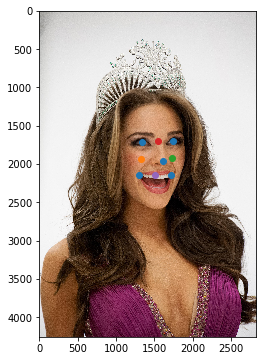

('Top-bottom', 0.64596546, 'left right', 2.2963049)
(4256, 2832, 3)
[[ 1339.  1715.]
 [ 1747.  1698.]
 [ 1611.  1962.]
 [ 1305.  2149.]
 [ 1713.  2140.]]
shrink


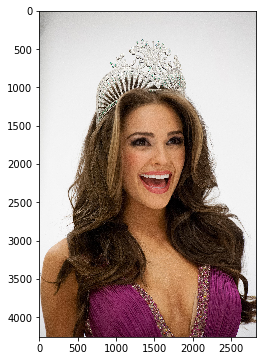

crop


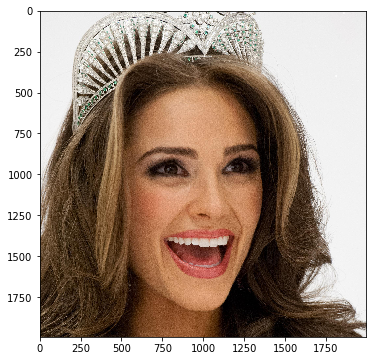

superres


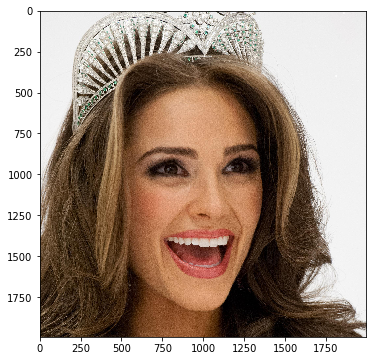

pad
(1993, 1993, 3)


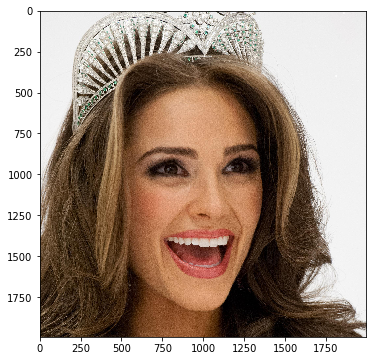

transform


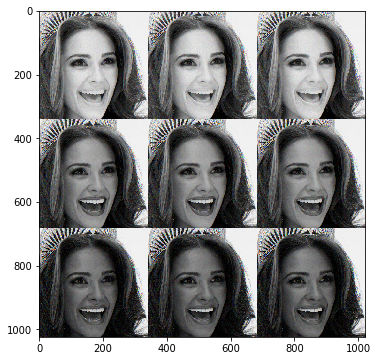

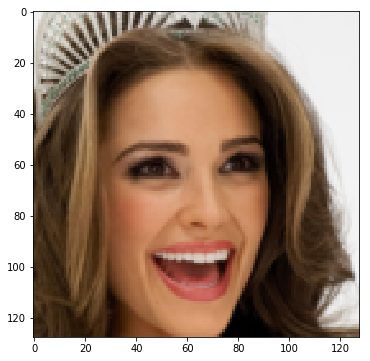

1


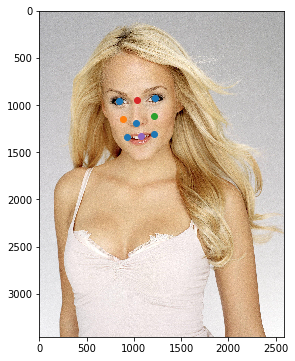

('Top-bottom', 0.6459077, 'left right', 0.70774865)
(3455, 2594, 3)
[[  847.   957.]
 [ 1220.   929.]
 [ 1027.  1185.]
 [  930.  1343.]
 [ 1213.  1302.]]
shrink


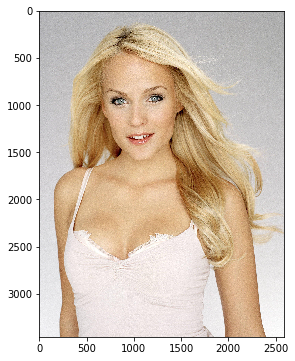

crop


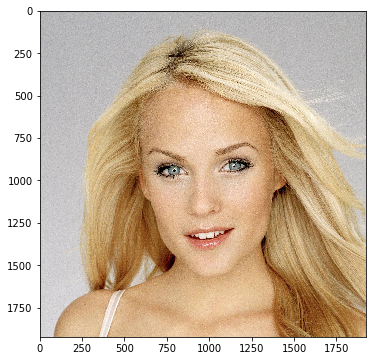

superres


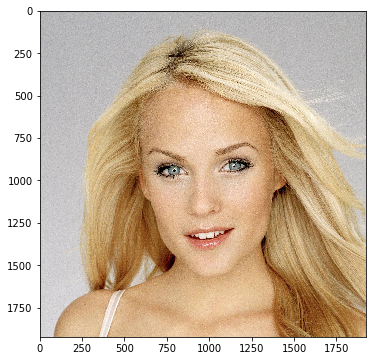

pad
(1923, 1922, 3)


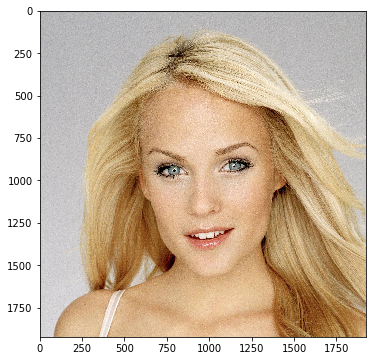

transform


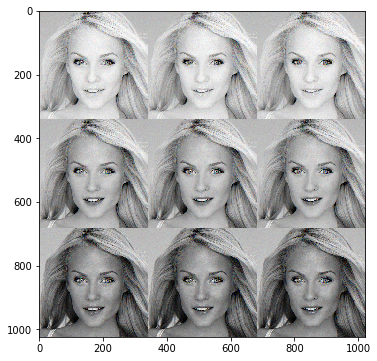

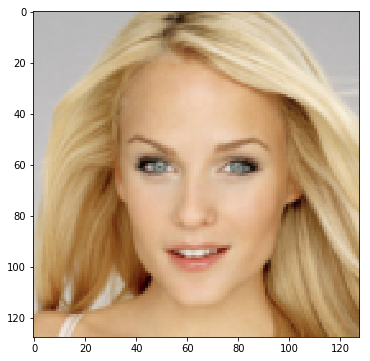

In [22]:
for idx in tqdm(fields['idx'][:2]):
    print(idx)
    _= ds.process_img_celeb_hq(celeba_dir=celeba_dir,delta_dir=delta_dir,idx=idx,
                               lm=landmarks[fields['orig_idx'][idx]],
                               orig_idx = fields['orig_idx'][idx], 
                               orig_file = fields['orig_file'][idx], 
                               proc_md5 = fields['proc_md5'][idx],
                               final_md5 = fields['final_md5'][idx],
                               final_size = dim, verbose=True)

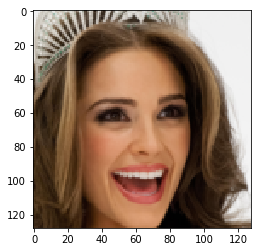

In [30]:
plt.imshow(img.reshape(dim,dim,3))

HBox(children=(IntProgress(value=0, max=2), HTML(value=u'')))

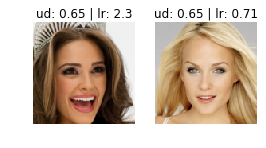

In [69]:
imsize = 2; nex = 2
fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(imsize*nex,imsize))
for i,idx in enumerate(tqdm(fields['idx'][:nex])):
    img,  up_down, left_right, idx = ds.process_img_celeb_hq(celeba_dir=celeba_dir,delta_dir=delta_dir,idx=idx,
                               lm=landmarks[fields['orig_idx'][idx]],
                               orig_idx = fields['orig_idx'][idx], 
                               orig_file = fields['orig_file'][idx], 
                               proc_md5 = fields['proc_md5'][idx],
                               final_md5 = fields['final_md5'][idx],
                               final_size = dim, verbose=False)
    if img is None:
        ax[i].axis('off'); continue
    ax[i].imshow(np.reshape(img/255., (dim,dim,3)), interpolation="None"); ax[i].axis('off')
    ax[i].set_title('ud: '+str(round(up_down,2)) +' | lr: '+ str(round(left_right,2)))
plt.show()

### Create dataset

In [156]:
n_jobs = 15 # adjust this based on how many threads you can use
chunk_size =  n_jobs*20 # adjust this based on how much memory you have available

In [157]:
size = 128
path = 'data/CELEBA-'+str(size)+'-Annot-hq.h5'

In [158]:
# create reservoir list of each data item
# grab a chunk
# remove the bad parts
# add that data to the reservoir list

In [163]:
np.shape(attrs_body)

(202599, 40)

In [166]:
dset_size = 1000 #len(attrs_body)

In [173]:
with Parallel(n_jobs=n_jobs, verbose=0) as parallel:
    with h5py.File(path, 'w') as f:
        # prepare dataasets
        dset_label_input = f.create_dataset('attrs_head', data = np.string_(attrs_head + ['left_right', 'up_down']))
        dset = f.create_dataset('images', (0,dim*dim*3), maxshape=(None,dim*dim*3),
                                dtype='i8', chunks=(chunk_size,dim*dim*3))
        dset_attrs = f.create_dataset('attrs', (0,42), maxshape=(None,42),
                                dtype='float32', chunks=(chunk_size,42))
        
        # loop through chunks
        for chunk in tqdm(np.arange(dset_size // chunk_size)):
            imgs, up_down, left_right, idxs = np.array(parallel(delayed(ds.process_img_celeb_hq)( 
                celeba_dir=celeba_dir,delta_dir=delta_dir,idx=idx,
                lm=landmarks[fields['orig_idx'][idx]],
                orig_idx = fields['orig_idx'][idx], 
                orig_file = fields['orig_file'][idx], 
                proc_md5 = fields['proc_md5'][idx],
                final_md5 = fields['final_md5'][idx],
                final_size = dim, verbose=False
                        ) for i, (idx) in enumerate(tqdm(fields['idx'][chunk_size*chunk:chunk_size*(chunk+1)])))).T

            # grab only the good parts of the data
            mask = up_down != None
            good_images = np.stack(imgs[mask])
            good_attrs = np.hstack([attrs_body[idxs[mask].astype('int')], np.vstack(left_right[mask]), np.vstack(up_down[mask])])
    
            # add to dataset
            dset.resize(dset.shape[0]+len(good_images), axis=0)
            dset[-len(good_images):] = good_images
            dset_attrs.resize(dset_attrs.shape[0]+len(good_attrs), axis=0)
            dset_attrs[-len(good_attrs):] = good_attrs
            
            # sdd flipped data to dataset
            dset.resize(dset.shape[0]+len(good_images), axis=0)
            dset[-len(good_images):] = np.flip(good_images.reshape((len(good_images), size, size, 3)), axis = 2).reshape(np.shape(good_images))
            dset_attrs.resize(dset_attrs.shape[0]+len(good_attrs), axis=0)
            dset_attrs[-len(good_attrs):] = np.hstack([attrs_body[idxs[mask].astype('int')], 1./np.vstack(left_right[mask]), np.vstack(up_down[mask])])
            


HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

Skipping file because hex did not Match
('d477277500042d27f70467b91297e450', '6858e9aab0278ecfcb5b54a7755c757c')
Skipping file because hex did not Match
('30372318e1520a211c12ea2f78fbe504', 'c333a2eed17691468e9bfef920388623')
Skipping file because hex did not Match
('d38683c44121cc096ddc75d29f0617e8', '9f9328d4aacd6e2c679034992505fa7b')
Skipping file because hex did not Match
('247b50f5ee7dcb66187718974be1c057', '54d15a07c7357194eaf481cb9e69a374')
Skipping file because hex did not Match
('53ae607b9e8809b5c6d82752f0034921', '218137c67e18593008b21799b2d3f9fd')
Skipping file because hex did not Match
('a0666083a80abeb83b80c8566540350d', '82532468e93b8d45ba021cb36ca4d9ab')
Skipping file because hex did not Match
('68d224fe272e9c2ec92c5777442cdbb7', 'fbfd1a306c9037171ee8fa920fedc66a')
Skipping file because hex did not Match
('5e640771e40120119e40a8568d2d4fb9', '7f49f32ff30bf1d4cfb50bd606c8146d')
Skipping file because hex did not Match
('749f75919735b8dd6e0f282f1857d123', '56f86ab26db07c5330

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

Skipping file because hex did not Match
('12ac3bcd7c10ea8d1d5db970ce519769', 'ecccdfee9d37c7472131af5cccca42ac')
Skipping file because hex did not Match
('0fa1ddad2a830fd2d897803748f5a948', '88b57fa0cb18c8905b7b3513678851aa')
Skipping file because hex did not Match
('3619a12656c87c3e10ee02fccf58c04f', 'cf4d3bc417e4b87006ffd62a6d8dfc2f')
Skipping file because hex did not Match
('8a7e2a4dffabbaaa39da8d2a9d89fdc9', 'c710a71935d70d4d70692f5adeb88d51')
Skipping file because hex did not Match
('650e3cebe611133db43af2565b880386', '014cca276f6e42de68087a65be125319')
Skipping file because hex did not Match
('56c41e4053a9ec3ff5a9cef1fca2cba5', 'e2b5ccffed189eca614b03a8f827815d')
Skipping file because hex did not Match
('e5bda22c9e7ff81aff4c6ebcafc5347c', 'fa738d7ebc6bd8cee44483b8aa8fb820')
Skipping file because hex did not Match
('3c31680dad8e43a2d34a00a1708d429d', '445d5e94cf2e276e652f7f937497ba69')
Skipping file because hex did not Match
('98180fd0aa750f7070aa59882622b9a6', '67ef1211cc9f8f2ab9

HBox(children=(IntProgress(value=0, max=300), HTML(value=u'')))

Skipping file because hex did not Match
('f020233a53d769efbf1edc0217f01032', '5ab694bf72605c1f06b34155bcbe1af3')
Skipping file because hex did not Match
('0451aa904090d058d7952770b98d4e14', 'c56ae1b13ac76f143e0082b3e0f0e11a')
Skipping file because hex did not Match
('07b72f4e5187b6d72f66b76fdb0a6ec0', '7dfd08e9a21c715074f47ffb7f40f9b1')
Skipping file because hex did not Match
('df86ec823aae6e1e96e28dfb1b0571ae', '6730da4e261c148880461819fc913e3b')
Skipping file because hex did not Match
('467b8c6f341ecb20736c1b85ccc98977', 'b506732295bba0b50c87ee30127c15d2')
Skipping file because hex did not Match
('6f06a483a16d6491a77dba5b3b788686', '46312827357e837d46523bbb65d09af6')
Skipping file because hex did not Match
('7767f489b035149aed69950a638f7e96', '116dd8c2c20c7c83f6bb5d1ee7a85f03')
Skipping file because hex did not Match
('b743a54fe8b351481db696c499cc629d', 'ffb202a0713d0a3515db64e9c23dc44f')
Skipping file because hex did not Match
('aca5132b29707c3a69c51af9bcdd2cbb', '2cf1bd0c466564bf85

In [172]:
np.shape(np.flip(good_images.reshape((len(good_images), size, size, 3)), axis = 2).reshape(np.shape(good_images)))

(231, 49152)

### Test read a face

In [26]:
with h5py.File(path, 'r') as hf:
    face = hf['images'][1]
    print(len(hf['images']))

239100


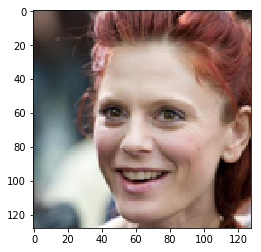

In [27]:
plt.imshow(face.reshape((dim,dim,3)))

In [28]:
with h5py.File(path, 'r') as hf:
    faces = hf['images'][:200]

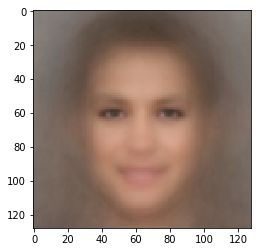

In [29]:
plt.imshow(np.reshape(np.mean(faces, axis = 0)/255, (dim,dim,3)))

In [30]:
nx = 5
ny = 15
canvas = np.zeros((dim*nx,dim*ny,3), dtype='uint8')
for x in np.arange(nx):
    for y in np.arange(ny):
        canvas[x*dim:(x+1)*dim,y*dim:(y+1)*dim,:] = faces[x*ny+y].reshape((dim,dim,3))

(-0.5, 1919.5, 639.5, -0.5)

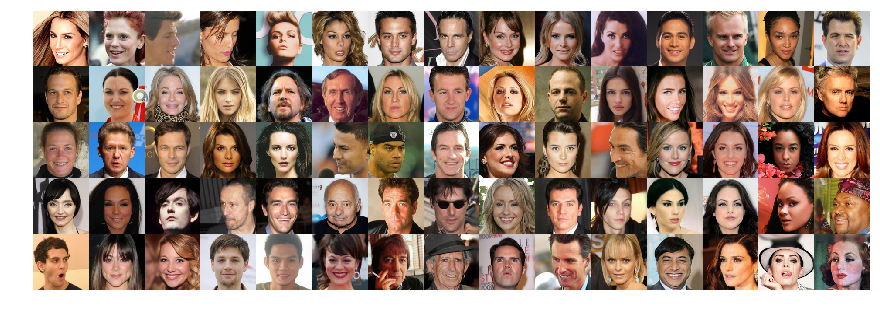

In [31]:
z =3
fig, ax = plt.subplots(figsize=(nx*z, ny*z))
ax.imshow(canvas)
ax.axis('off')

### Test read attributes

In [32]:
ex = 900
with h5py.File(path, 'r') as hf:
    print(len(hf['images']))
    face = hf['images'][ex]
    attrs = hf['attrs'][ex]
    print(list(hf.keys()))

239100
['attrs', 'attrs_head', 'images']


In [33]:
print(' | '.join([str(i)+' '+j for i,j in enumerate(attrs_head)]))

0 5_o_Clock_Shadow | 1 Arched_Eyebrows | 2 Attractive | 3 Bags_Under_Eyes | 4 Bald | 5 Bangs | 6 Big_Lips | 7 Big_Nose | 8 Black_Hair | 9 Blond_Hair | 10 Blurry | 11 Brown_Hair | 12 Bushy_Eyebrows | 13 Chubby | 14 Double_Chin | 15 Eyeglasses | 16 Goatee | 17 Gray_Hair | 18 Heavy_Makeup | 19 High_Cheekbones | 20 Male | 21 Mouth_Slightly_Open | 22 Mustache | 23 Narrow_Eyes | 24 No_Beard | 25 Oval_Face | 26 Pale_Skin | 27 Pointy_Nose | 28 Receding_Hairline | 29 Rosy_Cheeks | 30 Sideburns | 31 Smiling | 32 Straight_Hair | 33 Wavy_Hair | 34 Wearing_Earrings | 35 Wearing_Hat | 36 Wearing_Lipstick | 37 Wearing_Necklace | 38 Wearing_Necktie | 39 Young


['Attractive' 'Brown_Hair' 'Heavy_Makeup' 'High_Cheekbones'
 'Mouth_Slightly_Open' 'No_Beard' 'Oval_Face' 'Pointy_Nose' 'Smiling'
 'Wearing_Earrings' 'Wearing_Lipstick']


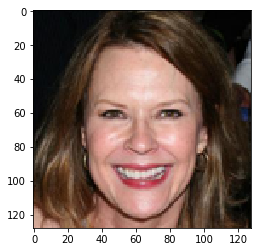

In [34]:
plt.imshow(face.reshape((dim,dim,3)))
print(np.array(attrs_head)[attrs[:40]==1])

In [35]:
with h5py.File(path, 'r') as hf:
    face = hf['images'][-1000:]
    attrs = hf['attrs'][-1000:]
    print(list(hf.keys()))

['attrs', 'attrs_head', 'images']


In [36]:
attr_num = 9
attrs_head[attr_num]

'Blond_Hair'

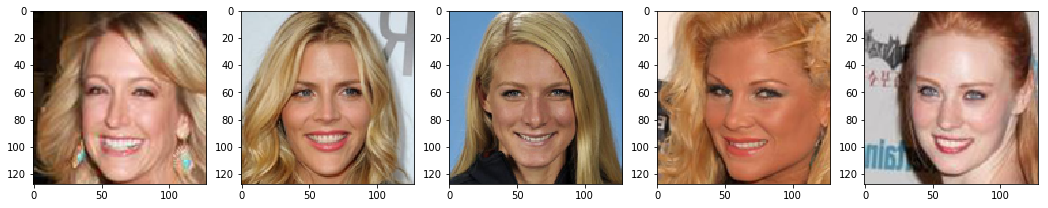

In [37]:
zoom = 3
fig, ax = plt.subplots(nrows=1,ncols=5, figsize=(6*zoom,6*5*zoom))
for i,face_i in enumerate(face[attrs[:,attr_num]==1][-5:]):
    ax[i].imshow(face_i.reshape((dim,dim,3)))

### Test face direction attribute

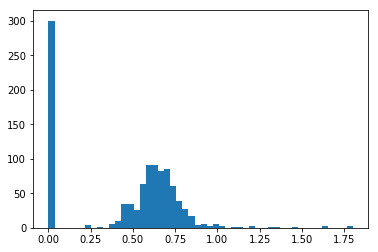

In [39]:
#_= plt.hist(np.log(attrs[:,-1]), bins = 50)
_= plt.hist(attrs[:,-1], bins = 50)

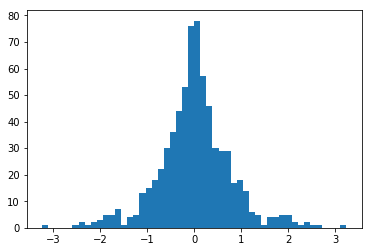

In [45]:
_= plt.hist(np.log(attrs[:,-2][attrs[:,-2] !=0]), bins = 50)
#_= plt.hist(attrs[:,-2], bins = 50)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


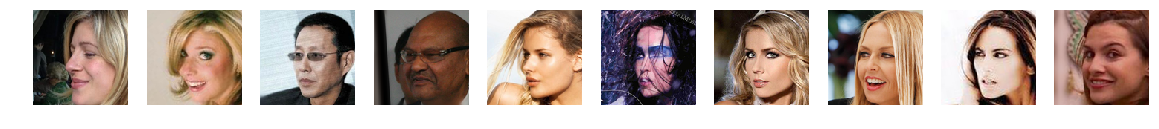

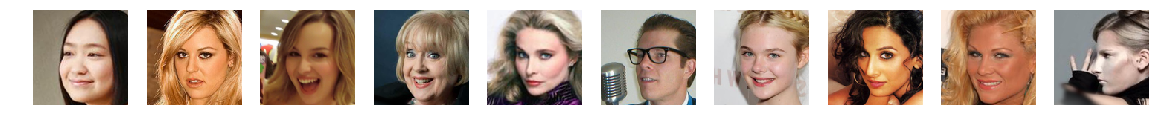

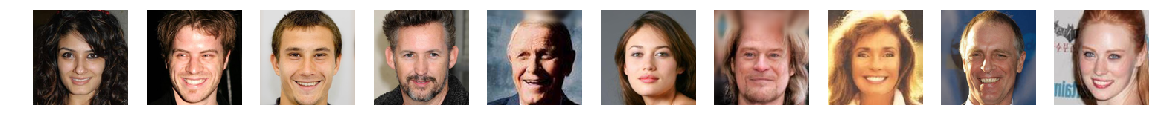

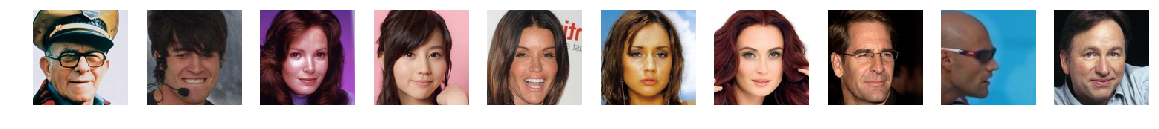

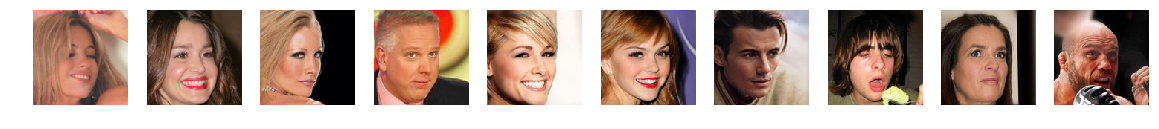

In [46]:
# left right
zoom = 2
nex = 10
for dirup,dirdown in zip(np.linspace(-2.5,2.5,7)[1:], np.linspace(-2,2,6)[:-1]):
    fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(zoom*nex,zoom))
    f = face[(np.log(attrs[:,-2]) < dirup) & (np.log(attrs[:,-2]) > dirdown)][-nex:]
    for i in range(len(f)): ax[i].imshow(f[i].reshape((dim,dim,3))); ax[i].axis('off')
    plt.show()

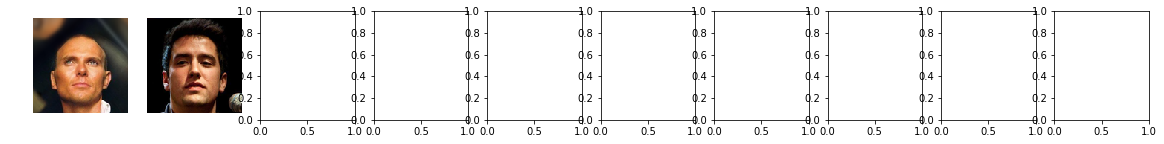

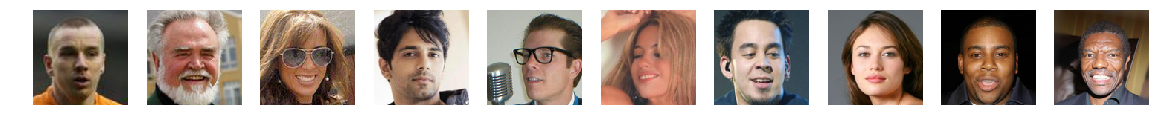

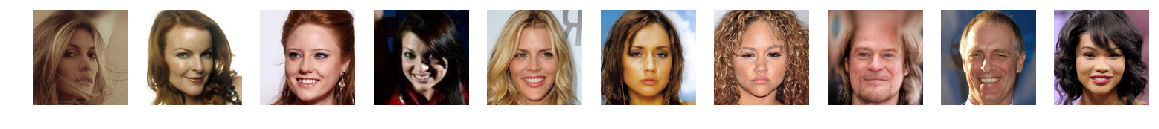

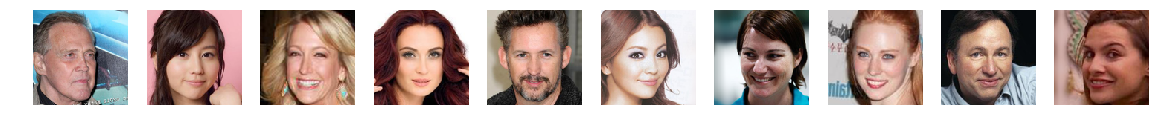

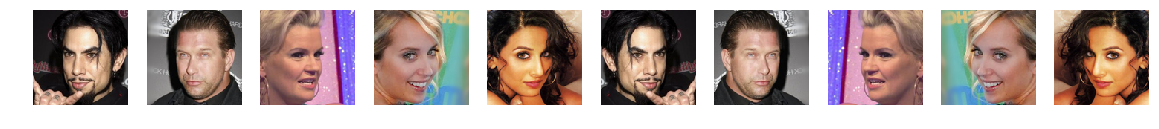

In [51]:
# up down 
zoom = 2
nex = 10
for dirup,dirdown in zip(np.linspace(.25,1,7)[1:], np.linspace(.25,1,6)[:-1]):
    fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(zoom*nex,zoom))
    f = face[((attrs[:,-1]) < dirup) & ((attrs[:,-1]) > dirdown)][-nex:]
    for i in range(len(f)): ax[i].imshow(f[i].reshape((dim,dim,3))); ax[i].axis('off')
    plt.show()